In [20]:
# ====== 1. Import Library Dasar ======
import os
import time
from pathlib import Path
from datetime import datetime, timedelta, timezone

import requests
import pandas as pd
from dotenv import load_dotenv


In [21]:
# ====== 2. Load .env & Setup Project Path ======

# Asumsi notebook disimpan di folder `preprocessing/` atau `notebooks/`
# dan .env ada di root project (satu level di atas folder ini)
PROJECT_ROOT = Path.cwd().parent   # kalau notebook di /preprocessing, ini naik 1 level
ENV_PATH = PROJECT_ROOT / ".env"

print("PROJECT_ROOT:", PROJECT_ROOT)
print(".env path:", ENV_PATH)

# Load environment variable
load_dotenv(ENV_PATH)

API_KEY = os.getenv("YOUTUBE_API_KEY")
if API_KEY is None:
    raise ValueError("YOUTUBE_API_KEY belum diset di file .env")

print("API key loaded:", "OK" if API_KEY else "FAILED")


PROJECT_ROOT: c:\Aldy-Kuliah\Semester 7\mlOps\project\Eksperimen_SML_Aldy-Naufal
.env path: c:\Aldy-Kuliah\Semester 7\mlOps\project\Eksperimen_SML_Aldy-Naufal\.env
API key loaded: OK


In [22]:
# ====== 3. Konfigurasi Dasar & Genre Keywords ======

BASE_SEARCH_URL = "https://www.googleapis.com/youtube/v3/search"
BASE_VIDEOS_URL = "https://www.googleapis.com/youtube/v3/videos"

# Folder output untuk menyimpan hasil scraping
OUT_DIR = PROJECT_ROOT / "data"
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR


WindowsPath('c:/Aldy-Kuliah/Semester 7/mlOps/project/Eksperimen_SML_Aldy-Naufal/data')

In [23]:
# ====== 3b. Genre Mapping Berbasis Keyword ======

GENRE_KEYWORDS = {
    "MOBA": [
        "mobile legends", "mlbb", "arena of valor", "aov", "league of legends",
        "lol pc", "wild rift", "dota 2", "ml", "dota"
    ],
    "FPS": [
        "valorant", "csgo", "counter strike", "cs2", "call of duty", "codm",
        "apex legends", "overwatch", "valo", "delta force"
    ],
    "Battle Royale": [
        "pubg", "pubg mobile", "free fire", "ff", "fortnite", "warzone"
    ],
    "RPG": [
        "genshin impact", "honkai star rail", "star rail",
        "zenless zone zero", "zzz", "elden ring", "final fantasy",
        "persona", "rpg"
    ],
    "Horror": [
        "outlast", "amnesia", "phasmophobia", "poppy playtime",
        "fnaf", "five nights at freddy", "horror game", "game horror"
    ],
    "Sandbox": [
        "minecraft", "roblox", "terraria", "sandbox"
    ],
    "Sports": [
        "fifa", "ea fc", "pes", "efootball", "nba 2k", "football manager"
    ],
    "Racing": [
        "forza", "gran turismo", "need for speed", "nfs", "f1 23", "f1 24",
        "assetto corsa"
    ],
    "Strategy": [
        "age of empires", "civilization", "clash of clans", "coc",
        "clash royale", "strategy game"
    ],
    "Casual/Party": [
        "stumble guys", "fall guys", "party game", "jackbox"
    ],

    "Simulation": [
    "bus simulator", "truck simulator", "ets2", "euro truck",
    "simulator", "driving simulator", "farming simulator",
    "train simulator", "flight simulator"
    ],

}

GENRE_KEYWORDS


{'MOBA': ['mobile legends',
  'mlbb',
  'arena of valor',
  'aov',
  'league of legends',
  'lol pc',
  'wild rift',
  'dota 2',
  'ml',
  'dota'],
 'FPS': ['valorant',
  'csgo',
  'counter strike',
  'cs2',
  'call of duty',
  'codm',
  'apex legends',
  'overwatch',
  'valo',
  'delta force'],
 'Battle Royale': ['pubg',
  'pubg mobile',
  'free fire',
  'ff',
  'fortnite',
  'warzone'],
 'RPG': ['genshin impact',
  'honkai star rail',
  'star rail',
  'zenless zone zero',
  'zzz',
  'elden ring',
  'final fantasy',
  'persona',
  'rpg'],
 'Horror': ['outlast',
  'amnesia',
  'phasmophobia',
  'poppy playtime',
  'fnaf',
  'five nights at freddy',
  'horror game',
  'game horror'],
 'Sandbox': ['minecraft', 'roblox', 'terraria', 'sandbox'],
 'Sports': ['fifa', 'ea fc', 'pes', 'efootball', 'nba 2k', 'football manager'],
 'Racing': ['forza',
  'gran turismo',
  'need for speed',
  'nfs',
  'f1 23',
  'f1 24',
  'assetto corsa'],
 'Strategy': ['age of empires',
  'civilization',
  'clash

In [24]:
# ====== 4. Helper: YouTube Search ======

def youtube_search(query, max_results=200, published_after=None, published_before=None):
    """
    Mengambil daftar video_id hasil search YouTube.
    - query: kata kunci pencarian
    - max_results: total video yang mau diambil (bukan per page)
    - published_after / published_before: ISO timestamp (string)
    """
    video_ids = []
    next_page_token = None
    fetched = 0

    while fetched < max_results:
        to_fetch = min(50, max_results - fetched)
        params = {
            "key": API_KEY,
            "part": "snippet",
            "type": "video",
            "q": query,
            "maxResults": to_fetch,
            "order": "viewCount",   # fokus video yang cukup populer
            "regionCode": "ID",     # region Indonesia
        }
        if published_after:
            params["publishedAfter"] = published_after
        if published_before:
            params["publishedBefore"] = published_before
        if next_page_token:
            params["pageToken"] = next_page_token

        resp = requests.get(BASE_SEARCH_URL, params=params)
        resp.raise_for_status()
        data = resp.json()

        items = data.get("items", [])
        for item in items:
            video_ids.append(item["id"]["videoId"])

        fetched += len(items)
        next_page_token = data.get("nextPageToken")
        if not next_page_token:
            break

        # jeda sedikit supaya tidak spam API
        time.sleep(0.2)

    # hapus duplikat dengan menjaga urutan
    return list(dict.fromkeys(video_ids))


In [25]:
# ====== 4b. Helper: YouTube Video Stats ======

def youtube_get_videos_stats(video_ids):
    """
    Mengambil detail & statistik video (viewCount, likeCount, dll).
    YouTube API batasi max 50 ID per request.
    """
    records = []

    for i in range(0, len(video_ids), 50):
        chunk = video_ids[i:i+50]
        params = {
            "key": API_KEY,
            "part": "snippet,statistics,contentDetails",
            "id": ",".join(chunk),
        }
        resp = requests.get(BASE_VIDEOS_URL, params=params)
        resp.raise_for_status()
        data = resp.json()

        for item in data.get("items", []):
            vid = item["id"]
            snippet = item.get("snippet", {})
            stats = item.get("statistics", {})
            content = item.get("contentDetails", {})

            tags = snippet.get("tags", [])
            if isinstance(tags, list):
                tags_joined = "|".join(tags)
            else:
                tags_joined = ""

            record = {
                "video_id": vid,
                "title": snippet.get("title"),
                "description": snippet.get("description"),
                "tags": tags_joined,
                "channel_id": snippet.get("channelId"),
                "channel_title": snippet.get("channelTitle"),
                "published_at": snippet.get("publishedAt"),
                "view_count": int(stats.get("viewCount", 0)),
                "like_count": int(stats.get("likeCount", 0)),
                "comment_count": int(stats.get("commentCount", 0)),
                "duration": content.get("duration"),  # format ISO 8601 (PTxxMxxS)
            }
            records.append(record)

        time.sleep(0.2)

    return pd.DataFrame(records)


In [26]:
# ====== 5. Helper: Deteksi Genre ======

def detect_genres_from_text(title: str, description: str, tags: str):
    """
    Mengembalikan list genre yang terdeteksi dari kombinasi
    title + description + tags.
    """
    parts = []
    if title:
        parts.append(title)
    if description:
        parts.append(description)
    if tags:
        parts.append(tags)

    if not parts:
        return []

    text = " ".join(parts).lower()
    found_genres = set()

    for genre, keywords in GENRE_KEYWORDS.items():
        for kw in keywords:
            if kw.lower() in text:
                found_genres.add(genre)
                break

    return list(found_genres)


In [27]:
# ====== 5b. Tambahkan kolom genres_list & primary_genre ======

def add_primary_genre_column(df_videos: pd.DataFrame) -> pd.DataFrame:
    genres_all = []
    primary = []

    for _, row in df_videos.iterrows():
        g_list = detect_genres_from_text(
            row.get("title", ""),
            row.get("description", ""),
            row.get("tags", ""),
        )
        genres_all.append(g_list)
        primary.append(g_list[0] if g_list else None)

    df_videos = df_videos.copy()
    df_videos["genres_list"] = genres_all
    df_videos["primary_genre"] = primary
    return df_videos


In [28]:
# ====== 5c. Explode per (video, genre) ======

def explode_by_genre(df_videos: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for _, row in df_videos.iterrows():
        genres = row.get("genres_list", [])
        if not genres:
            continue

        for g in genres:
            rows.append({
                "video_id": row["video_id"],
                "genre": g,
                "title": row["title"],
                "channel_title": row["channel_title"],
                "published_at": row["published_at"],
                "view_count": row["view_count"],
                "like_count": row["like_count"],
                "comment_count": row["comment_count"],
            })

    if not rows:
        return pd.DataFrame(columns=[
            "video_id", "genre", "title", "channel_title",
            "published_at", "view_count", "like_count", "comment_count"
        ])

    return pd.DataFrame(rows)


In [29]:
# ====== 5d. Aggregasi ranking genre & channel ======

def aggregate_genre_ranking(df_genre: pd.DataFrame) -> pd.DataFrame:
    if df_genre.empty:
        return pd.DataFrame(columns=["genre", "total_views", "total_videos", "avg_views"])

    agg = (
        df_genre.groupby("genre")
        .agg(
            total_views=("view_count", "sum"),
            total_videos=("video_id", "nunique"),
            avg_views=("view_count", "mean"),
        )
        .reset_index()
        .sort_values("total_views", ascending=False)
    )
    return agg


def aggregate_channel_ranking(df_videos: pd.DataFrame) -> pd.DataFrame:
    if df_videos.empty:
        return pd.DataFrame(columns=["channel_title", "total_views", "total_videos", "avg_views"])

    agg = (
        df_videos.groupby("channel_title")
        .agg(
            total_views=("view_count", "sum"),
            total_videos=("video_id", "nunique"),
            avg_views=("view_count", "mean"),
        )
        .reset_index()
        .sort_values("total_views", ascending=False)
    )
    return agg


In [30]:
# ====== 6. Scraping YouTube Gaming & Simpan CSV ======

# Range waktu: misal 90 hari terakhir
now = datetime.now(timezone.utc)
published_after = (now - timedelta(days=90)).isoformat()
published_before = now.isoformat()

QUERIES = [
    "game indonesia",
    "gaming indonesia",
    "mobile game indonesia",
    "pc game indonesia",
]

all_video_ids = []

for q in QUERIES:
    print(f"[INFO] Mencari video gaming dengan query: {q}")
    vids = youtube_search(
        query=q,
        max_results=200,  # per query
        published_after=published_after,
        published_before=published_before,
    )
    print(f"[INFO]   → dapat {len(vids)} video_id")
    all_video_ids.extend(vids)

# Hapus duplikat
all_video_ids = list(dict.fromkeys(all_video_ids))
print(f"[INFO] Total unique video_id: {len(all_video_ids)}")

if not all_video_ids:
    raise RuntimeError("Tidak ada video yang ditemukan. Coba ganti query/range tanggal.")


[INFO] Mencari video gaming dengan query: game indonesia
[INFO]   → dapat 136 video_id
[INFO] Mencari video gaming dengan query: gaming indonesia
[INFO]   → dapat 196 video_id
[INFO] Mencari video gaming dengan query: mobile game indonesia
[INFO]   → dapat 187 video_id
[INFO] Mencari video gaming dengan query: pc game indonesia
[INFO]   → dapat 133 video_id
[INFO] Total unique video_id: 569


In [31]:
# ====== 6b. Ambil detail & statistik video ======

df_videos = youtube_get_videos_stats(all_video_ids)
print(df_videos.shape)
df_videos.head()


(569, 11)


,video_id,title,description,tags,channel_id,channel_title,published_at,view_count,like_count,comment_count,duration
0,zo7i8VTpfNM,"Would You Risk Dying For $500,000?",i cant believe he did that at the end\nJack Li...,,UCX6OQ3DkcsbYNE6H8uQQuVA,MrBeast,2025-09-27T16:00:04Z,99413077,2090335,29439,PT25M26S
1,Yqq5UbDVTWI,"If You Dig It, You Keep It!","If you find the expensive item in the sand, yo...",Ben Azelart|Stay Wild|Stay Wild Vlogs|Cam Huff...,UClQ3NafOy_42dJ0toK3QUKw,Stay Wild,2025-10-19T16:32:39Z,23803195,327244,12310,PT43M50S
2,9OHRtUHezTk,"$10,000 Every Boss You Beat",The new Feastables Hazelnut Cups are now avail...,,UCIPPMRA040LQr5QPyJEbmXA,MrBeast Gaming,2025-08-23T16:00:22Z,20400555,351311,4825,PT26M43S
3,xwfJ2TalgpM,"Clean The Sports Car, Keep It!",We competed in a satisfying sports car cleanin...,Ben Azelart|Stay Wild|Stay Wild Vlogs|Cam Huff...,UClQ3NafOy_42dJ0toK3QUKw,Stay Wild,2025-11-09T16:57:04Z,9163585,100076,4667,PT32M6S
4,mpyk0XKUCo8,ASMR Keyboard Clicky VS Keyboard Madu! [Roblox...,Jangan lupa subscribe channel utamaku Fanny Tj...,roblox|roblox indonesia|roblox obby|pastel obb...,UCdDoEvtA9Hl0g7d6dvgGtYw,Fanny Tjandra TV,2025-10-20T06:00:44Z,13206007,81809,1294,PT26S


In [32]:
# ====== 6c. Simpan raw ======

raw_path = OUT_DIR / "videos_raw.csv"
df_videos.to_csv(raw_path, index=False, encoding="utf-8")
raw_path


WindowsPath('c:/Aldy-Kuliah/Semester 7/mlOps/project/Eksperimen_SML_Aldy-Naufal/data/videos_raw.csv')

In [33]:
# ====== 7. Tambah kolom genres_list & primary_genre ======

df_with_genre = add_primary_genre_column(df_videos)
print(df_with_genre[["title", "primary_genre"]].head(10))

with_genre_path = OUT_DIR / "videos_with_genre.csv"
df_with_genre.to_csv(with_genre_path, index=False, encoding="utf-8")
with_genre_path


                                               title  primary_genre
0                 Would You Risk Dying For $500,000?           None
1                        If You Dig It, You Keep It!  Battle Royale
2                        $10,000 Every Boss You Beat        Sandbox
3                     Clean The Sports Car, Keep It!  Battle Royale
4  ASMR Keyboard Clicky VS Keyboard Madu! [Roblox...        Sandbox
5                   Most Expensive Art Wins $10,000!  Battle Royale
6  Lagu Anak Anak | Suka Hati ⭐️ | Bahasa Indones...  Battle Royale
7  Game ini Terlalu Susah Buat Ditamatin !! Horor...           None
8  GAGAL MULU DI RASA INI TOWER! [Roblox Indonesi...        Sandbox
9  Yuk Jadi Tukang Nasi Goreng - Obsessed Night S...         Horror


WindowsPath('c:/Aldy-Kuliah/Semester 7/mlOps/project/Eksperimen_SML_Aldy-Naufal/data/videos_with_genre.csv')

In [34]:
# ====== 7b. Explode per (video, genre) ======

df_genre = explode_by_genre(df_with_genre)
print(df_genre.shape)
df_genre.head()

exploded_path = OUT_DIR / "videos_genre_exploded.csv"
df_genre.to_csv(exploded_path, index=False, encoding="utf-8")
exploded_path


(654, 8)


WindowsPath('c:/Aldy-Kuliah/Semester 7/mlOps/project/Eksperimen_SML_Aldy-Naufal/data/videos_genre_exploded.csv')

In [35]:
# ====== 7c. Ranking genre ======

df_genre_rank = aggregate_genre_ranking(df_genre)
genre_rank_path = OUT_DIR / "genre_view_ranking.csv"
df_genre_rank.to_csv(genre_rank_path, index=False, encoding="utf-8")

df_genre_rank.head(10)


,genre,total_views,total_videos,avg_views
6,Sandbox,316255273,101,3.131240e+06
0,Battle Royale,284110620,153,1.856932e+06
4,MOBA,82054262,50,1.641085e+06
7,Simulation,45266423,203,2.229873e+05
3,Horror,24220439,30,8.073480e+05
8,Sports,18085394,39,4.637281e+05
5,RPG,17030657,37,4.602880e+05
9,Strategy,5463671,17,3.213924e+05
2,FPS,4198044,22,1.908202e+05
1,Casual/Party,419113,2,2.095565e+05


In [36]:
# ====== 7d. Ranking channel (top gamers) ======

df_channel_rank = aggregate_channel_ranking(df_with_genre)
channel_rank_path = OUT_DIR / "channel_view_ranking.csv"
df_channel_rank.to_csv(channel_rank_path, index=False, encoding="utf-8")

df_channel_rank.head(10)


,channel_title,total_views,total_videos,avg_views
224,Stay Wild,104538424,8,1.306730e+07
169,MrBeast,99413077,1,9.941308e+07
147,MPL Indonesia,71758977,12,5.979915e+06
69,Fanny Tjandra TV,62553746,12,5.212812e+06
211,Roblox Noob,55619882,1,5.561988e+07
30,Ben Azelart,50379600,2,2.518980e+07
170,MrBeast Gaming,48213775,3,1.607126e+07
221,Spizee,44102555,1,4.410256e+07
249,Windah Basudara,38166381,27,1.413570e+06
159,MiawAug,28260246,25,1.130410e+06


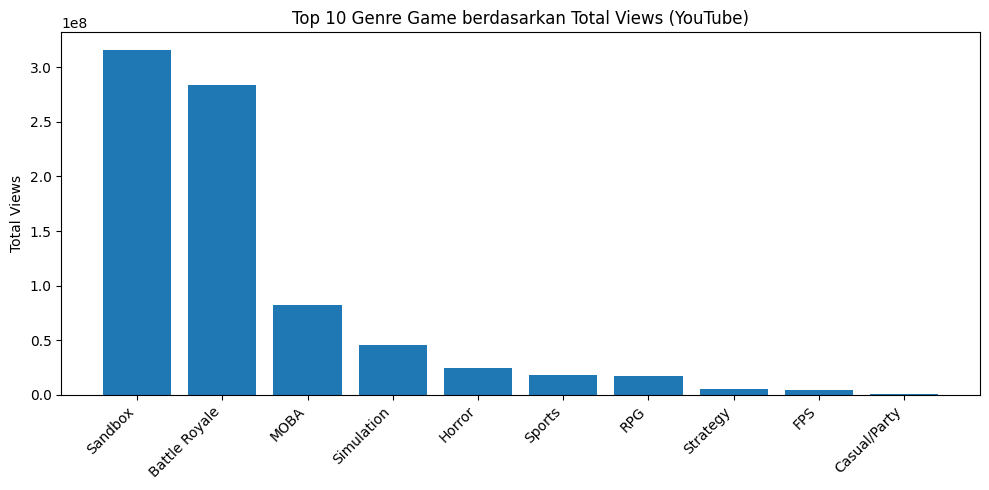

In [37]:
# ====== 8. Quick EDA: Top 10 Genre by Total Views ======
import matplotlib.pyplot as plt

# Ambil top 10 genre
top_genres = df_genre_rank.head(10).copy()

# Pastikan tidak kosong
if top_genres.empty:
    print("Data top_genres kosong, tidak bisa di-plot.")
else:
    # x = posisi bar (0, 1, 2, ...)
    x = list(range(len(top_genres)))

    # label genre sebagai list Python biasa
    x_labels = top_genres["genre"].astype(str).tolist()

    # tinggi bar (total_views) juga list float biasa
    heights = [float(v) for v in top_genres["total_views"].tolist()]

    plt.figure(figsize=(10, 5))
    plt.bar(x, heights)  # x numerik, y float
    plt.xticks(x, x_labels, rotation=45, ha="right")
    plt.ylabel("Total Views")
    plt.title("Top 10 Genre Game berdasarkan Total Views (YouTube)")
    plt.tight_layout()
    plt.show()


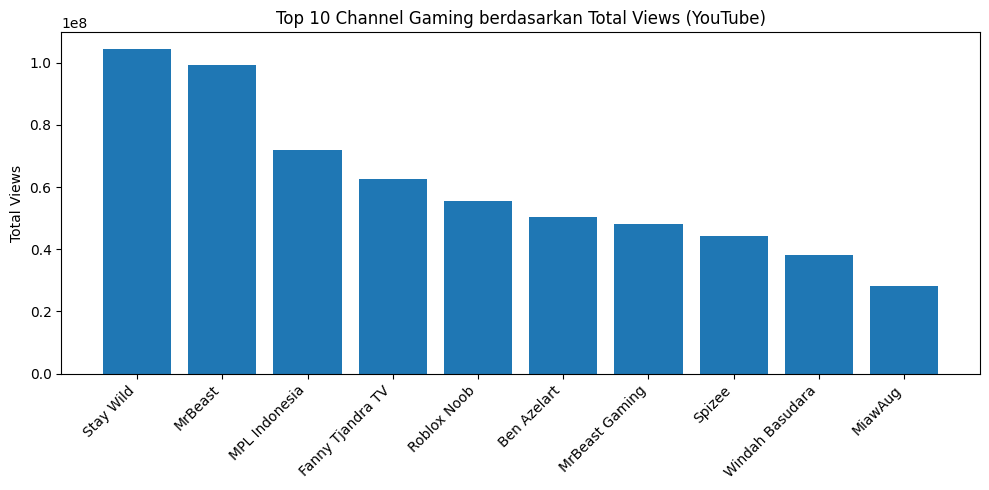

In [38]:
# ====== 8b. Quick EDA: Top 10 Channel (Gamers) by Total Views ======

top_channels = df_channel_rank.head(10)

plt.figure(figsize=(10, 5))
plt.bar(top_channels["channel_title"], top_channels["total_views"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Total Views")
plt.title("Top 10 Channel Gaming berdasarkan Total Views (YouTube)")
plt.tight_layout()
plt.show()
